# Alfvenic Turbulence in Quasilinear theory

In [1]:
"""Preliminary Setup"""

import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline
from code.plot_utils import plot_pretty

plot_pretty()

In [2]:
"""Basic definitions"""
# constants (cgs units)
mp = 1.673e-24       # ion (proton) mass
mp2e = 1836.15267389 # proton to electron mass ratio
qe = 4.803e-10       # elementary charge
c = 2.998e10         # speed of light
kB = 1.3807e-16      # Boltzmann constant

# plasma properties
n0 = 1.e10              # plasma number density
T = 1.e6                # ion temperature
vth = np.sqrt(kB*T/mp)  # ion thermal speed

# box
lz = 10.**9       # x dimension
lx, ly = 1., 1.   # y and z dimensions (small compared to lx)

# excited modes
B0 = 1.e4                      # ambient magnetic field, in +z direction
vA = B0/np.sqrt(4*np.pi*n0*mp) # alfven speed
Wtot = 1.e-3                   # total wave energy density
q = 2.                         # power-spectrum index: W(k) = k^-q

# frequencies
omegac = qe*B0/(mp*c)                 # ion gyrofrequency
omegap = np.sqrt(4*np.pi*n0*qe**2/mp) # ion plasma frequency

In [3]:
"""Adopted code units"""
# r0 (length): skin depth, vA/omegac = c/omegap
r0 = vA/omegac

# m0 (mass): ion mass, mi
m0 = mp

# t0 (time): inverse gyrofrequency, 1/Omegac
t0 = 1./omegac

# v0 (velocity): alfven speed, vA
v0 = vA

# B0 (magnetic field): B0

# E0 (electric field): vA*B0/c
E0 = vA*B0/c

## Waves

Starting from
$$W_k \equiv \frac{|B_k|^2}{8 \pi} = C_k k^{-q},$$
where
$$C_k = \frac{(1-q) W_{\rm tot}}{k_{\min}^{1-q}} \left[ \left( \frac{k_{\max}}{k_{\min}} \right)^{1-q} - 1 \right]^{-1}$$
and $W_{\rm tot}$ is the total wave energy, we can write
$$|B_\mathbf{k}| = 2\sqrt{2\pi C_k} k^{-q/2}.$$

Also, since $|B_\mathbf{k}| = |\mathbf{k} \times \mathbf{A}_\mathbf{k}| = |kA_\mathbf{k} \sin (\pi/2 - \theta_\mathbf{k})|$, we also get
$$|A_\mathbf{k}| = \frac{2\sqrt{2\pi C_k}}{\cos \theta_\mathbf{k}} k^{-1-q/2} \; .$$

$\theta_\mathbf{k}$ is distributed according to a normal distribution around $\pi/4$. 

In units of $W_m = B_0^2/8\pi$, the energy of the waves is
$$ \tilde{W}_{\rm tot} = |\delta \tilde{B}|^2 \equiv \left( \frac{|\delta B|}{B_0} \right)^2 \equiv R^2 \; , $$
which is th parameter that determines how strong the waves are. We will formulate our code in terms of that.

Then, for instance, in code units where the energy unit is $E_0 = B_0^2/8\pi$, 
$$ \tilde{C}_k = \frac{(1-q)R^2}{\tilde{k}_{\max}^{1-q} - \tilde{k}_{\min}^{1-q}} \; $$
where $C_{k,0} = (B_0^2/8 \pi)(v_A/\Omega)^{1-q}$ are its units. Also, then, the units of $W_\mathbf{k}$ are $W_{k,0} = (B_0^2/8 \pi)(v_A/\Omega)$.


Also, note that, for the electric field, we write
$$ \mathbf{E} = - \frac{1}{c} \frac{\partial \mathbf{A}}{\partial t} = - \frac{1}{c} \frac{\partial}{\partial t} \sum \limits_{k=k_{\min}}^{k_{\max}} \mathbf{A}_\mathbf{k} \cos \left( \omega_\mathbf{k} t - \mathbf{k} \cdot \mathbf{x} + \phi_\mathbf{k} \right) = \sum \limits_{k=k_{\min}}^{k_{\max}} \mathbf{A}_\mathbf{k} \frac{\omega_\mathbf{k}}{c} \sin \left( \omega_\mathbf{k} t - \mathbf{k} \cdot \mathbf{x} + \phi_\mathbf{k} \right) \; ,$$
and $E_0 = v_A B_0/c$ are the units of the electric field and $A_0 =v_A B_0/\Omega$ are the unit of the vector potential. Finally, the dimrnsionless Electric field expression is
$$ \tilde{\mathbf{E}} = \sum \limits_{\tilde{k}=\tilde{k}_{\min}}^{\tilde{k}_{\max}} \tilde{\mathbf{A}}_\mathbf{k} \tilde{\omega}_\mathbf{k} \sin \left( \omega_\mathbf{k} t - \mathbf{k} \cdot \mathbf{x} + \phi_\mathbf{k} \right) \; ,$$

In [4]:
"""The excited Alfven spectrum"""
# wavevector
# note: k is parallel to +z direction
Nk = 2**9                 # number of excited modes
kmin, kmax = 1.e-1, 1.e4  # minimum and maximum k
lkmin, lkmax = np.log10(kmin), np.log10(kmax)
k_array = 10**np.linspace(lkmin, lkmax, Nk)

# random phase array
import numpy.random as rnd
phi_k = rnd.uniform(0., 2*np.pi, Nk)

# array of theta_k values
# note: they are chosen in a random manner
#       for moderate angles around pi/4
theta_k = rnd.normal(np.pi/4., np.pi/16., Nk)

def Wk_norm(R, k=k_array):
    """
    Normalization factor of Wk
    """
    return (1.-q) * R**2 / ( k_array[-1]**(1.-q) - k_array[0]**(1.-q) )

def omegak(k=k_array, thetak=theta_k):
    """
    Dispersion relation
    omega(k) = k.vA = k*vA*cos(theta) = k*vA
    note: vA is parallel to B0 and so is k
    note: it is written in the normalized units
    ......i.e. vA=1, k_cgs = k*(1/r0) = k*(omegac/vA)

    input
    -----
    k: numpy array
        normalized wavenumber
    thetak: numpy array
        angle between B0 (+z direction) and k
        
    output
    ------
    omegak: numpy array
        wave frequency per mode k
    """
    return k * np.cos(thetak)

def Wk(k, t, R):
    """
    Wave energy power spectrum
    (in units of [B0^2/8*pi]*[vA/Omega] = [energy]/[k])
    
    input
    -----
    k: numpy array
        normalized wavenumber
    t: float
        time moment
    """
    Ck = Wk_norm(R)
    
    return Ck * k**-q

def delta_E(x, t, R, k=k_array, theta_k=theta_k, phi_k=phi_k):
    """
    Spectral components of magnetic field
    
    input
    -----
    k: numpy array
        normalized wavenumber
    t: float
        time moments
    """
    # amplitude of deltaB_k
    Ck = Wk_norm(R)
    ampl_k = np.sqrt(Ck) * k**(-q/2.) * omegak()
    
    Nx = len(x[:,0])
    deltaE = np.zeros(Nx)
    for i in range(Nx):
        # dot product of k and x: k.x = k*x*sin(theta_k) + k*z*cos(theta_k)
        k_dot_x = k * x[i,0] * np.sin(theta_k) + k * x[i,2] * np.cos(theta_k)
        
        # phase of deltaB_k
        phase_k = np.sin(omegak()*t - k_dot_x + phi_k)
        
        # deltaB at position i, at time t
        deltaE[i] = np.sum(ampl_k*phase_k)
        
    return deltaE

def delta_B(x, t, R, k=k_array, theta_k=theta_k, phi_k=phi_k):
    """
    Spectral components of magnetic field
    
    input
    -----
    k: numpy array
        normalized wavenumber
    t: float
        time moments
    """
    # amplitude of deltaB_k
    Ck = Wk_norm(R)
    ampl_k = np.sqrt(Ck) * k**(-q/2.)
    
    Nx = len(x[:,0])
    deltaB = np.zeros(Nx)
    for i in range(Nx):
        # dot product of k and x: k.x = k*x*sin(theta_k) + k*z*cos(theta_k)
        k_dot_x = k * x[i,0] * np.sin(theta_k) + k * x[i,2] * np.cos(theta_k)
        
        # phase of deltaB_k
        phase_k = np.cos(omegak()*t - k_dot_x + phi_k)
        
        # deltaB at position i, at time t
        deltaB[i] = np.sum(ampl_k*phase_k)
        
    return deltaB

def compute_deltaB_deltaE(x, t, R, k=k_array, theta_k=theta_k, phi_k=phi_k):
    """
    Computes delta_B and delta_E at the same time at (x,t)
    
    input
    -----
    k: numpy array
        normalized wavenumber
    t: float
        time moments
    """
    # amplitude of deltaB_k and deltaE_k
    Ck = Wk_norm(R)
    amplB_k = np.sqrt(Ck) * k**(-q/2.)
    amplE_k = np.sqrt(Ck) * k**(-1.-q/2.) * omegak()
    
    Nx = len(x[:,0])
    deltaB = np.zeros(Nx)
    deltaE = np.zeros(Nx)
    for i in range(Nx):
        # dot product of k and x: k.x = k_x*x + k_z*z = k*x*sin(theta_k) + k*z*cos(theta_k)
        k_dot_x = k * x[i,0] * np.sin(theta_k) + k * x[i,2] * np.cos(theta_k)
        
        # phase of deltaB_k
        phaseB_k = np.cos(omegak()*t - k_dot_x + phi_k)
        # phase of deltaE_k
        phaseE_k = np.sin(omegak()*t - k_dot_x + phi_k)
        
        # deltaB at position i, at time t
        deltaB[i] = np.sum(amplB_k*phaseB_k)
        # deltaE at position i, at time t
        deltaE[i] = np.sum(amplE_k*phaseE_k)
        
    return deltaB, deltaE

## Particle integration

The equations of motion for the ions are
$$\frac{d(\gamma \boldsymbol{\beta})}{dt} = \frac{e}{mc}\left( \mathbf{E} + \boldsymbol{\beta} \times \mathbf{B} \right) \; ,$$
where
$$ \gamma = \frac{1}{\sqrt{1 - \beta^2}} \; . $$

The dimensionalized ones are expressed as
$$ \frac{d\mathbf{\tilde{v}}}{d \tilde{t}} = - \frac{1}{\gamma} \frac{d \gamma}{d\tilde{t}} \mathbf{\tilde{v}} + \delta \tilde{\mathbf{E}} + \tilde{\mathbf{v}} \times \left( \hat{\mathbf{e}}_z + \delta \tilde{B} \; \hat{\mathbf{e}}_y \right) $$
with
$$\gamma = \frac{1}{\sqrt{1 + (v_A/c)^2 \tilde{v}^2}} \; .$$
We also have that 
$$\frac{d\gamma}{dt} = \frac{\gamma^3}{c^2} \mathbf{v} \cdot \frac{d\mathbf{v}}{dt} \; \; \Rightarrow \; \; \frac{d\gamma}{d\tilde{t}} = \left[ \left( \frac{c}{\gamma v_A} \right)^2 + \tilde{v}^2 \right]^{-1} \gamma \delta \tilde{E} \; \tilde{v}_x \; .$$

We will drop the tilde symbols for convenience, since all equations are non-dimensional from now on. Then, the equations of motion become
$$ \frac{dv_x}{dt} = \left( \frac{1}{\gamma} - f v_x^2 \right) \delta E + \frac{1}{\gamma} v_y - \frac{\delta B}{\gamma} v_z $$
$$ \frac{dv_y}{dt} = - \frac{1}{\gamma} v_x - f \delta E v_x v_y $$
$$ \frac{dv_x}{dt} =   \frac{\delta B}{\gamma} v_x - f \delta E v_x v_z $$
where 
$$ f \equiv \left[ \left( \frac{c}{\gamma v_A} \right)^2 + \tilde{v}^2 \right]^{-1} \; . $$

### Stability analysis (in progress...)

The particle with the maximum velocity, say $v_{\max}$, travels $\Delta x = v_{\max} \Delta t$ in a time step. Lets say that this distance must be a fraction $f$ of a full gyromotion, $\ell_g = 2 \pi r_L = 2 \pi v_{\perp , \max} / \Omega$, i.e.
$$ \Delta x \leq f \ell_g \; \; \Rightarrow \; \; \Delta \tilde{t} \leq 2 \pi f \frac{v_{\perp , \max}}{v_{\max}} $$

In [5]:
def gamma(v):
    """
    Lorentz factor
    
    input
    -----
    v: numpy array or float
        dimensionless velocity
    outout
    ------
    gamma Lorentz factor for every particle and an array
    """
    v2 = np.sum(v*v,1)
    return 1. / np.sqrt(1. - (vA/c)**2 * v2)

def Ekin(v):
    """
    Kinetic energy of particles
    (in units of mp*vA^2)
    
    input
    -----
    v: numpy array
        normalized velocities
    outout
    ------
    kinetic energy for every particle and an array
    """
    return (gamma(v)-1.) * (c/vA)**2.

def compute_acc(x, v, t, R):
    """Acceleration at position x and time t"""
    # magnetic and electric fields at (x,t)
    deltaB, deltaE = compute_deltaB_deltaE(x, t, R)
    
    v2 = np.sum(v*v,1); gL = gamma(v)
    fact = 1. / ( (c/(gL*vA))**2 + v2 )
    
    # rhs of equations of motion
    dvdt_x = (1./gL - fact * v[:,0]**2) * deltaE + v[:,1]/gL - deltaB * v[:,2] / gL
    dvdt_y = - v[:,0] / gL - fact * deltaE * v[:,0] * v[:,1]
    dvdt_z = deltaB * v[:,0] / gL - fact * deltaE * v[:,0] * v[:,2]
    return np.array(zip(dvdt_x, dvdt_y, dvdt_z))

def DKD_step(x, v, t, dt, dth, R):
    """
    Symplectic stepping scheme (similar to leap-frog method)
    1) First, the position of a particle is advanced by half time step (1st-order Euler scheme)
    2) Then, the velociy is updated by full time step using the positions at half time step
    3) Finally, the new position at full step size is computed using the new velocity
    
    input
    -----
    x: numpy vector
        positions
    v: numpy vector
        velocities
    dt: float
        step size
    dth: float
        half step size
    
    output
    ------
    x, v: numpy arrays
        updated positions and velocities after one time step
    """
    # position at t_i + dt/2 
    # (1st-order Euler scheme)
    x += v*dth
    
    # acceleration at position above
    acc = compute_acc(x, v, t+dth, R)
    
    # new velocity using updated position and acceleration
    v += acc*dt
    
    # full position update at t_{i+1} = t_i + dt
    x += v*dth
    return x, v
    
def particle_integration(nsteps, nsample, nprint, dt, x, v, R, Ekin=Ekin, step=DKD_step):
    """
        integrate equations of motions starting from the input vectors x, v, mp
        for nsteps with constant time step dt;
        
        input
        -----
        nsteps - integer
                the number of steps to take during integration
        nsample - integer
                record physical variables of particles (x, v, and Epot) only each nsample-th step
        nprint  - integer
                print physical quantities every nprint-th step
        dt - float
            step size
        x, v, mp - vectors of floats
             coordinates, velocities and masses of particles
        step - python function
            name of a user-supplied function to compute step using a given stepping scheme
            it should take x, v, mp, dt, dth=dt/2 as inputs
            
        Etot - python function 
            name of a user-supplied function to compute total energy for input x, v
             it should take into account the difference in time slices of x and v if such
             difference exists
        acc  - python function
            name of a user-supplied function to compute mutual accelerations of particles
            and/or accelerations from an external potential
        
        output
        ------
        tt - numpy float vector
            recorded trajectory times
        xt, vt, Ett - numpy float vectors
            coordinates, velocities, and total energies 
         
        these arrays are initialized as follows: 
            tt  = np.empty(nsteps/nsample+2)
            xt  = np.empty(shape=(nsteps/nsample+2,)+np.shape(x))
            vt  = np.empty(shape=(nsteps/nsample+2,)+np.shape(x))
            Ett = np.empty(shape=(nsteps/nsample+2,)+np.shape(x[:,0])) -> len(x[:,0])=Np
    """
    # initializations
    tt  = np.empty(nsteps/nsample+2)
    xt  = np.empty(shape=(nsteps/nsample+2,)+np.shape(x))
    vt  = np.empty(shape=(nsteps/nsample+2,)+np.shape(x))
    Ekt = np.empty(shape=(nsteps/nsample+2,)+np.shape(x[:,0]))

    # half time-step for DKD scheme's Euler step
    dth = 0.5*dt
    
    isample, t = 0, 0.
    # initial time, position, and kinetic energy for particles
    tt[0], xt[0], vt[0] = t, x, v
    
    for i in range(nsteps):
        # advance position, velocity, and time
        x, v = step(x, v, t, dt, dth, R)
        t += dt
        if not i%nprint:
            print("%d steps completed out of %d"%(i, nsteps))

        if not i%nsample:
            isample += 1
            xt[isample] = np.copy(x)
            vt[isample] = np.copy(v)
            tt[isample] = np.copy(t)
            Ekt[isample] = np.copy(Ekin(v))
    return tt, xt, vt, Ekt

def particle_init(Np):
    """
    Routine that initializes positions and velocities
    Positions are uniformly distributed
    Velocities are distributed normaly
    
    input
    -----
    Np: int
        number of particles
    
    output
    ------
    x_init: numpy array
        initial positions -> array of coordinates (x,y,z)
    v_init: numpy array
        initial velocities -> array of velocity-space coordinates (vx,vy,vz)
    """
    xmin, ymin, zmin = 0., 0., 0.
    xmax, ymax, zmax = 100., 100., 100.
    mu_v = 0.; sigma_v = vth/vA
    
    # positions: randomly in space
    x_init = rnd.uniform(xmin, xmax, Np)
    y_init = rnd.uniform(ymin, ymax, Np)
    z_init = rnd.uniform(zmin, zmax, Np)

    # velocities: normal distributions in velocity-space
    mu_v = 0.; sigma_v = vth/vA

    vx_init = rnd.normal(mu_v, sigma_v, Np)
    vy_init = rnd.normal(mu_v, sigma_v, Np)
    vz_init = rnd.normal(mu_v, sigma_v, Np)

    # pack-up initial conditions
    x_init = np.array(zip(x_init,y_init,z_init))
    v_init = np.array(zip(vx_init,vy_init,vz_init))
    return x_init, v_init

In [6]:
"""Initialize particles"""
# number of particles
Np = 5
x_init, v_init = particle_init(Np)

"""Integrate equations of motion"""
from time import time

# strength of magnetic field perturbations
R = 1.e-2

t = 0.; dt = 0.0005;
tmax = 1000000.*dt # end time in code units
nsteps = np.int(tmax/dt)-1
nsample = 10; nprint = 100000

t1 = time()
tout, xout, vout, Eout = particle_integration(nsteps, nsample, nprint, dt, x_init, v_init, R)
t2 = time()
print("integrated in %.2f seconds"%(t2-t1))

0 steps completed out of 999999
100000 steps completed out of 999999
200000 steps completed out of 999999
300000 steps completed out of 999999
400000 steps completed out of 999999
500000 steps completed out of 999999
600000 steps completed out of 999999
700000 steps completed out of 999999
800000 steps completed out of 999999
900000 steps completed out of 999999
integrated in 509.95 seconds


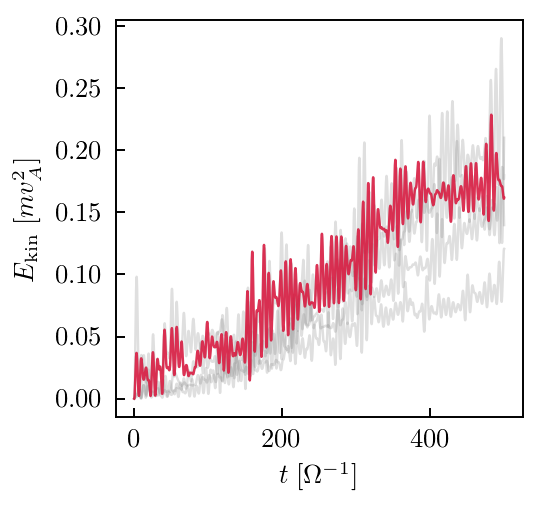

In [48]:
#fig = plt.figure(figsize=(9,9))
fig = plt.figure(figsize=(3,3))
#plt.xlim(15.0,15.);
#plt.yscale('log')
#plt.hist(vout[25][:,0], bins=30, normed=1.0, color='darkslateblue', alpha=0.9)

#plt.plot(xout[1:-1,0,0], xout[1:-1,0,1], lw=1., alpha=0.75, c='gray', label='target pdf')
#plt.scatter(xout[1,0,0], xout[1,0,1], lw=0.5, s=20.)
#plt.scatter(xout[-2,0,0], xout[-2,0,1], lw=0.5, s=20.)

#plt.plot(tout[1:-1], vout[1:-1,0:5,0], lw=1., alpha=0.75, c='crimson', label='target pdf')
plt.plot(tout[:], Eout[:,:], lw=1., alpha=0.25, c='gray', label='target pdf')
plt.plot(tout[:], Eout[:,3], lw=1., alpha=0.85, c='crimson', label='target pdf')

plt.xlabel(r'$t \; [\Omega^{-1}]$')
plt.ylabel(r'$E_{\rm kin} \; [mv_A^2]$')
#plt.legend(loc='upper right', frameon=False)

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 11}

plt.rc('font', **font)

plt.show()

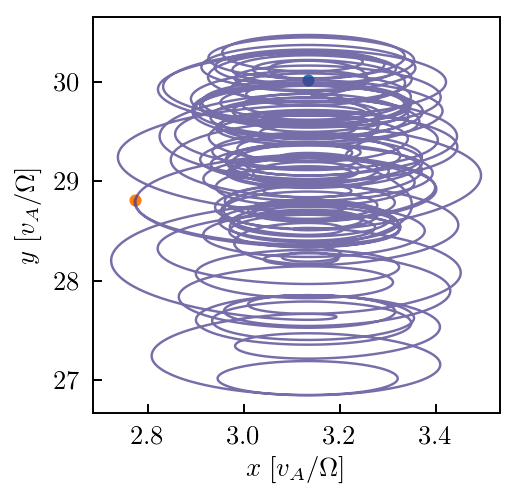

In [44]:
#fig = plt.figure(figsize=(9,9))
fig = plt.figure(figsize=(3,3))
#plt.xlim(15.0,15.);
#plt.yscale('log')
#plt.hist(vout[25][:,0], bins=30, normed=1.0, color='darkslateblue', alpha=0.9)

#plt.plot(xout[1:-1,:,0], xout[1:-1,:,1], lw=1., alpha=0.25, c='gray', label='target pdf')

ind = 1
plt.plot(xout[1:-1,ind,0], xout[1:-1,ind,1], lw=1., alpha=0.75, c='darkslateblue', label='target pdf')
plt.scatter(xout[0,ind,0], xout[0,ind,1], lw=0.5, s=20.)
plt.scatter(xout[-1,ind,0], xout[-1,ind,1], lw=0.5, s=20.)

plt.xlabel(r'$x \; [v_A/\Omega]$')
plt.ylabel(r'$y \; [v_A/\Omega]$')
#plt.legend(loc='upper right', frameon=False)

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 11}

plt.rc('font', **font)

plt.show()

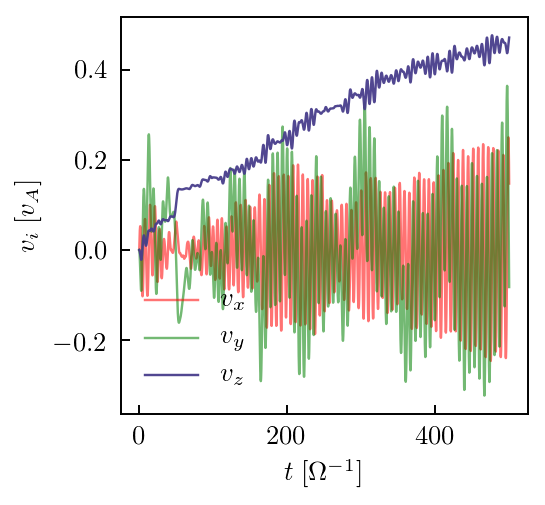

In [53]:
#fig = plt.figure(figsize=(9,9))
fig = plt.figure(figsize=(3,3))

ind = 0
plt.plot(tout, vout[:,ind,0], lw=1., alpha=0.55, c='r', label=r'$v_x$')
plt.plot(tout, vout[:,ind,1], lw=1., alpha=0.55, c='g', label=r'$v_y$')
plt.plot(tout, vout[:,ind,2], lw=1., alpha=0.95, c='darkslateblue', label=r'$v_z$')

plt.xlabel(r'$t \; [\Omega^{-1}]$')
plt.ylabel(r'$v_i \; [v_A]$')
plt.legend(loc='lower left', frameon=False)

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 11}

plt.rc('font', **font)

plt.show()